___
<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 


# SEGUNDO EXAMEN PARCIAL
# SIMULACIÓN DE PROCESOS FINANCIEROS

## Examen Tema 2- B)

## Nombre:  Luis María Ramiréz de la Rosa

## Fecha: 13 de noviembre del 2020

## Por: Oscar David Jaramillo Z.

In [38]:
import math  # Para el Factorial
import random
import numpy as np
import pandas as pd
import scipy.stats as st  
from scipy import optimize
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [39]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

def kde_sklearn_f(x, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    pdf = lambda x_grid: np.exp(kde_skl.score_samples(x_grid[:, np.newaxis]))
    return pdf

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, 
                          bw='cv_ml',  #bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)

kde_funcs = [kde_statsmodels_u, kde_scipy, kde_sklearn, kde_statsmodels_m]
kde_funcnames = ['Statsmodels-U', 'Scipy', 'Scikit-learn', 'Statsmodels-M']

In [40]:
data = pd.read_csv('Datos_b.csv')

# 1.
Usando la información reportada en el archivo `Datos_b.csv`, responda las siguientes preguntas:

a) **Para la columna 1 de su archivo `Datos_b.csv`**, utilice el método de kernel density estimation de su preferencia para ajustar un distribución de probabilidad a este conjunto de datos. Posteriormente, utilizar el método de aceptación y rechazo para generar 10000 muestras aleatorias de la distribución ajustada y en una misma figura graficar el histograma de los valores aleatorios obtenidos con el método de aceptación y rechazo y la distribución de probabilidad obtenido con el kernel density estimation, algo similar a la siguiente figura.

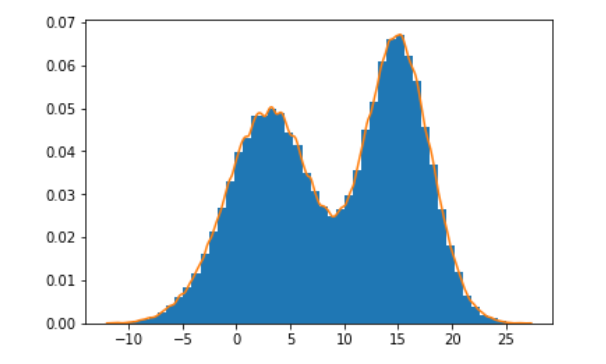

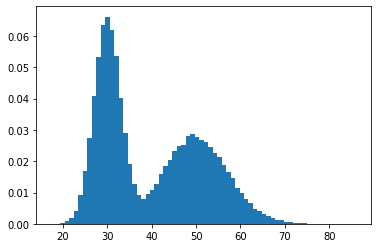

In [44]:
# Para visualizar la densidad de los datos hacemos un histograma:
plt.hist(np.array(data.iloc[:,0]), bins=68, density = True)
plt.show()

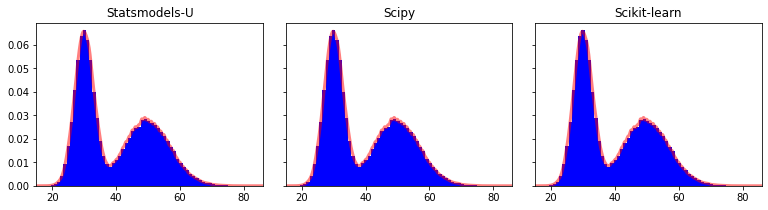

In [49]:
# Usando el Kernel Density Estimation
x = np.array(data.iloc[:,0]) # Data
x_grid = np.linspace(15, 86, 1000)  # El grid 
# Graficamos los kernel density estimates
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(13, 3))
fig.subplots_adjust(wspace=0.1)  # Espacio entre plots
bandwidth_ = 0.5  # Ajustamos el Bandwith para que se aproxime a la distribución
for i in range(3):
    pdf = kde_funcs[i](x, x_grid, bandwidth=bandwidth_)
    ax[i].hist(np.array(data.iloc[:,0]), bins=68, density = True, color='blue')  # Distribucion "real" con data
    ax[i].plot(x_grid, pdf, color='red', alpha=0.5, lw=3)  # Con el Kernel Densitity
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(15, 86)

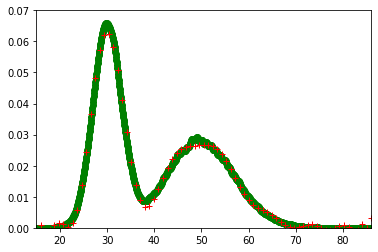

In [50]:
# Crear la función objetivo a partir de la línea roja usando polyfit.
x = x_grid
y = pdf
for x1, y1 in zip(x, y):
    plt.plot(x1, y1, 'go')
z = np.polyfit(x, y, 30)
f = np.poly1d(z)
for x1 in np.linspace(15, 86, 75):
    plt.plot(x1, f(x1), 'r+')
plt.axis([15, 86, 0, 0.07])
plt.show()

In [7]:
# Función de aceptación y rechazo usando compresión de listas
def Acep_rechazo_distribution(R2:'Variables distruidas U~U(0,1)', R1:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar', t:'función que mayora a f'):
    f_x = f(R1)
    t_x = t(R1)
    condition = R2*t_x <=f_x
    df = pd.DataFrame([R1,R2*t_x,np.zeros(len(R1))]).transpose()
    df[2] = [True if condition[i] else False for i in range(len(R1))]
    [plt.plot(R1[i],R2[i]*t_x[i],'ob') if df[2][i] == True else plt.plot(R1[i],R2[i]*t_x[i],'o') for i in range(len(R1))]          
    plt.show()
    return df

El máximo de f es: 0.06583662862803179


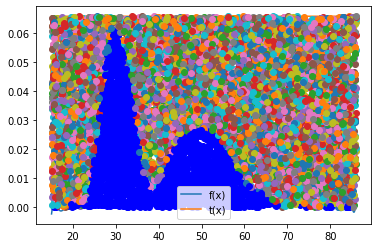

In [8]:
# Método de aceptación y rechazo cuando se toma t(x) constante
f = f # Función objetivo  
max_f = max(pdf) # Máximo de la función f
t = lambda x: max_f*np.ones(len(x)) # Función t -> Función constante
x = np.arange(15,86,0.01)  # Rango donde se graficará las funciones
print('El máximo de f es:',max_f)
# Gráficas de las funciones
plt.plot(x,f(x),label='f(x)')
plt.plot(x,t(x),label='t(x)')
plt.legend()
# Validación del método
N = 10000 # número de puntos a simular
# Como estoy tomando t(x) constante solo es necesario generar valores aleatorios 
# uniformer entre el dominio de la función f(x) que para este ejemplo es [15,90]. Por
# lo tanto yo debo de generar R1 como un uniforme entre U ~(15,90)
R2 = np.random.rand(N)
R1 = np.random.uniform(15,86,N)
MAR_df = Acep_rechazo_distribution(R2,R1,f,t)  # Regresa un DataFrame con Cada punto y si es Aceptado o Rechazado

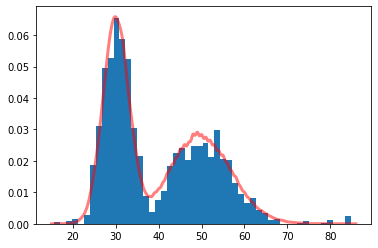

In [9]:
MAR_df = MAR_df[(MAR_df[2]==True)]   # Filtro solo los Aceptados
plt.hist(MAR_df[0], bins = 50, density = True)  # Hago un histograma de los datos aleatorios Simulados
plt.plot(x_grid, pdf, color='red', alpha=0.5, lw=3)  # Con el Kernel Densitity
plt.show()

b). **Para el conjunto de datos 2 y 3** de su archivo `Datos_b.csv` (columnas 2 y 3 de el correspondiente DataFrame), usando el método de quantil-quantil (Q-Q), determine la distribución de probabilidad de dicho conjunto de datos.(**Ayuda**: Optimicen la función que les envié para probar distribuciones de probabilidad usando el paquete estadístico, para que encuentren cual es la distribución de probabilidad más probable y puedan utilizar el método de Q-Q.)

(0.6746032511867088, 5.447431626801624)
(25.69146599950379, 4.140957888555059)


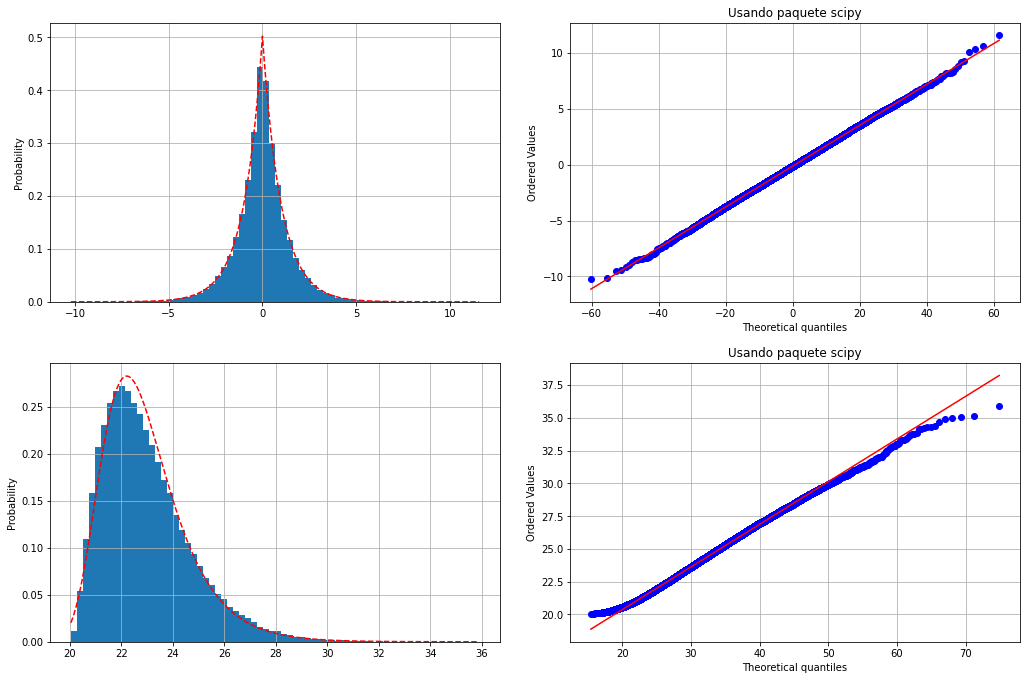

In [10]:
# DATA
measurements_1 = np.array(data.iloc[:,1])   
measurements_2 = np.array(data.iloc[:,2])   
# Parametros de las distribuciones
divisiones = 68 # Cantidad de barras en el histograma
dist_1 = 'laplace'
dist_2 = 'gumbel_r'
# GRAFICOS 
fig, ax = plt.subplots(2,2, figsize=(15,10))
fig.tight_layout(pad=4.0)
# PRIMERA DISTRIBUCIÓN
ax[0,0].hist(measurements_1,divisiones,density=True)  # Histograma
params = getattr(st, dist_1).fit(measurements_1)  # Parametros de la distribución que mejor se acomodan
x = np.arange(measurements_1.min(), measurements_1.max(), .01)  # Espacio en X
y = getattr(st, dist_1).pdf(x, *params)  # Graficar PDF de la distribución que queremos probar
ax[0,0].plot(x,y,'r--')
ax[0,0].set_ylabel('Probability')
ax[0,0].grid()
# gráfica de Q-Q entre mis datos y la curva que quiero probar que sigue mi distribución (dist): Usando scipy
grap2 = st.probplot(measurements_1, dist=dist_1, sparams=getattr(st, dist_1).fit(x)[:], plot=ax[0,1], fit=True)
ax[0,1].grid()
ax[0,1].set_title('Usando paquete scipy')
print(getattr(st, dist_1).fit(x)[:])
# SEGUNDA DISTRIBUCIÓN
ax[1,0].hist(measurements_2,divisiones,density=True)  # Histograma
params = getattr(st, dist_2).fit(measurements_2)  # Parametros de la distribución que mejor se acomodan
x = np.arange(measurements_2.min(), measurements_2.max(), .01)  # Espacio en X
y = getattr(st, dist_2).pdf(x, *params)  # Graficar PDF de la distribución que queremos probar
ax[1,0].plot(x,y,'r--')
ax[1,0].set_ylabel('Probability')
ax[1,0].grid()
# gráfica de Q-Q entre mis datos y la curva que quiero probar que sigue mi distribución (dist): Usando scipy
grap2 = st.probplot(measurements_2, dist=dist_2, sparams=getattr(st, dist_2).fit(x)[:], plot=ax[1,1], fit=True)
ax[1,1].grid()
ax[1,1].set_title('Usando paquete scipy')
print(getattr(st, dist_2).fit(x)[:])
plt.show()

In [11]:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
# POSIBLES CANDIDATOS
# gumbel_r, invweibull, kstwobign,  genlogistic, maxwell, rayleigh
# ncx2,
# TARDAN MUCHO EN CORRER
# st.cosine,st.exponnorm,st.foldcauchy,st.foldnorm,st.genexpon,st.gausshyper,st.invgauss,st.ksone,
# st.levy_stable,st.semicircular,st.mielke,st.ncf,st.nct,st.rdist,


c). Según los resultados concluidos con el método quantil-quantil, use el método de máxima verosimilitud en python, para estimar los parámetros `loc` y `scale` de las dos distribuciones de probabilidad ajustadas. Compare los resultados usando el histograma de los datos, (use bins=60) y su respectiva función de densidad ajustada. Los resultados esperados para cada distribución se deben de reportar como sigue:
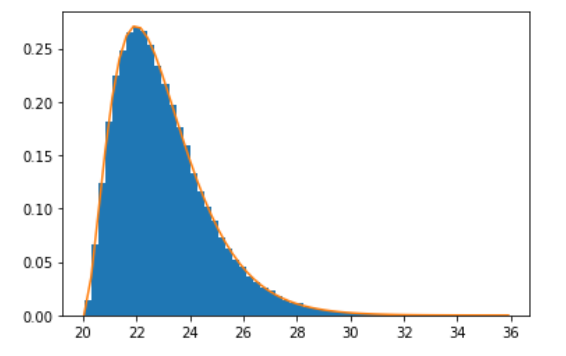


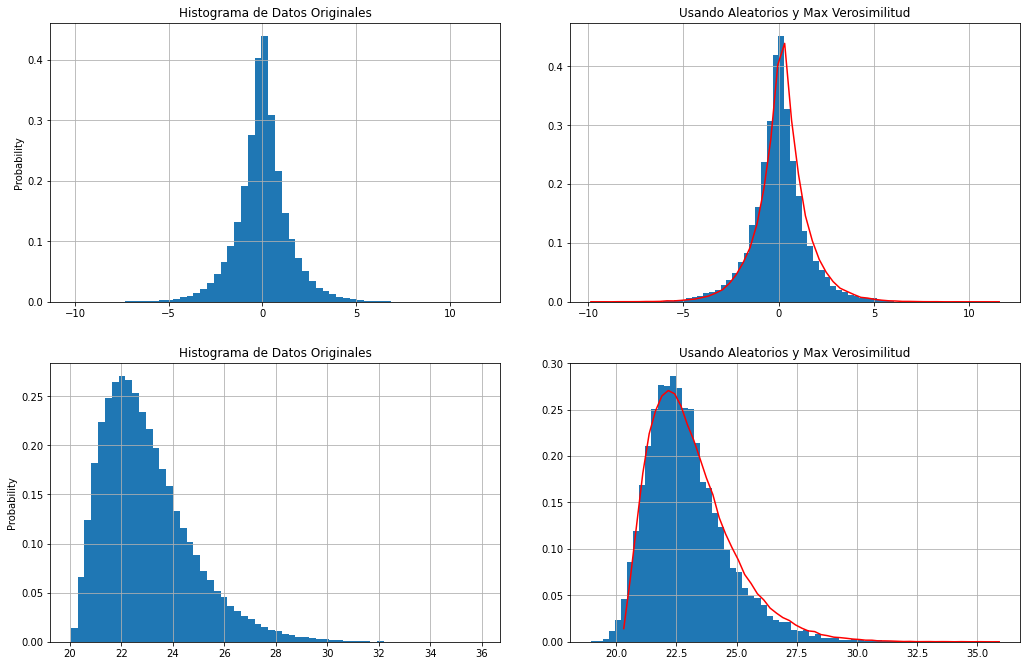

In [12]:
# DATA
loc_1, scale_1 = st.laplace.fit(measurements_1)  
loc_2, scale_2 = st.gumbel_r.fit(measurements_2)  
# Usando Maxima Verosimilitud
y_random_1 = st.laplace.rvs(loc=loc_1, scale=scale_1, size=10000)
y_random_2 = st.gumbel_r.rvs(loc=loc_2, scale=scale_2, size=10000)
# 
y_1, x_1, _ = plt.hist(measurements_1, bins=60, density = True)
y1, x1, _ = plt.hist(y_random_1, bins=60, density = True)
y_2, x_2, _ = plt.hist(measurements_2, bins=60, density = True)
y2, x2, _ = plt.hist(y_random_2, bins=60, density = True)
plt.close()
# GRAFICOS 
fig, ax = plt.subplots(2,2, figsize=(15,10))
fig.tight_layout(pad=4.0)
# PRIMERA DISTRIBUCIÓN
ax[0,0].hist(measurements_1, bins=60, density = True)  # Histograma
ax[0,0].set_ylabel('Probability')
ax[0,0].set_title('Histograma de Datos Originales')
ax[0,0].grid()
# Gráfica con Maxima Verosimilitud
ax[0,1].hist(y_random_1, bins=60, density = True)
ax[0,1].plot(x_1[1:], y_1, 'r')
ax[0,1].grid()
ax[0,1].set_title('Usando Aleatorios y Max Verosimilitud')
# SEGUNDA DISTRIBUCIÓN
ax[1,0].hist(measurements_2, bins=60, density = True)  # Histograma
ax[1,0].set_ylabel('Probability')
ax[1,0].set_title('Histograma de Datos Originales')
ax[1,0].grid()
# Gráfica con Maxima Verosimilitud
ax[1,1].hist(y_random_2, bins=60, density = True)
ax[1,1].plot(x_2[1:], y_2, 'r')
ax[1,1].grid()
ax[1,1].set_title('Usando Aleatorios y Max Verosimilitud')
plt.show()

In [13]:
print('Para la Primera Distribución: Loc='+str(loc_1)+' , Scale=' +str(scale_1) )
print('Para la Segunda Distribución: Loc='+str(loc_2)+' , Scale=' +str(scale_2) )

Para la Primera Distribución: Loc=0.004551194820093037 , Scale=0.9956856827120957
Para la Segunda Distribución: Loc=22.21679307611399 , Scale=1.3016299934879068


d). Use la prueba chi cuadrado - Usando el histograma (como se vió en clase), y los resultados del literal c) responda la siguiente prueba de hipótesis para cada distribución:

Observe que `paramétro 1` y `paramétro 2` dependerán de cada una de las distribuciones seleccionadas, por ejemolo si la `distribución_i` fuera normal entonces  `paramétro 1` y `paramétro 2` serían la media $\mu$ y desviación estándar $\sigma$, respectivamente.

**Nota:** Recuerde que el método de máxima verosimilitud puede estimar `loc` y `scale` únicamente o `loc` y `scale` y otros parámetros de la distribución a ajustar (ver por ejemplo clase 19, la explicación del uso del método fit, para aclarar).

### Para los datos de la Segunda Columna de la Base de Datos:
> $H_0$: la distribución es `laplace` con $\mu$ = 0.4950 y $b$ = 4.4460

> $H_a$: los datos no se distribuyen como `laplace`

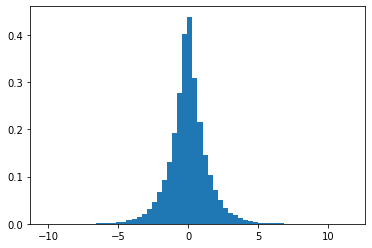

media mu =0.495061, parametro b =4.446018
Valor de chi cuadrado librería =  Power_divergenceResult(statistic=-45.67675398144929, pvalue=1.0)
Estadístico de chi_cuadrado =  75.62374846937608
NO se Rechaza H0


In [14]:
J = 60  # Cantidad de particiones del histograma
[freq, x, _] = plt.hist(measurements_1, J, density=True)
plt.show()
N = 10000 # Cantidad de muestras
x = x[:-1] # Se obvia el último valor de x para obtener exactamente J muestras de x
# Media y segundo parámetro muestral
mu = np.mean(x)
b = np.sqrt((np.std(x)**2)/2)
print('media mu =%f, parametro b =%f'%(mu,b))
pi = st.laplace.pdf(x, loc=mu, scale=b)
# Cálculo de la esperanza usando la expresión teórica
Ei = x*pi
# Cálculo usando la librería estadística de la chi cuadrada
X2 = st.chisquare(freq, Ei)
print('Valor de chi cuadrado librería = ', X2)
# Cálculo de Grados de libertad del estadístico
p = 2 # Parámetros estimados con los datos
m = J-p-1 # grados de libertad
Chi_est = st.chi2.ppf(q=0.95, df=m)
print('Estadístico de chi_cuadrado = ', Chi_est)
if X2[0] > Chi_est:
    print('Se Rechaza H0')
else:
    print('NO se Rechaza H0')

### Para los datos de la Tercera Columna de la Base de Datos:
> $H_0$: la distribución es `gumbel_r` con $\mu$ = 22.21679 y $\beta$ = 1.3016

> $H_a$: los datos no se distribuyen como `gumbel_r`

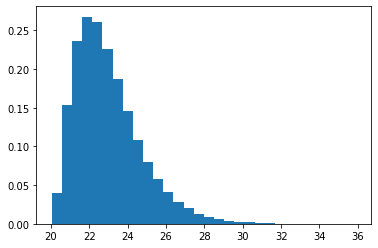

media mu =25.650843, parametro b =3.567598
Valor de chi cuadrado librería =  Power_divergenceResult(statistic=44.43691408291077, pvalue=0.03334542845882956)
Estadístico de chi_cuadrado =  46.962942124751436
NO se Rechaza H0


In [15]:
J = 30  # Cantidad de particiones del histograma
[freq, x, _] = plt.hist(measurements_2, J, density=True)
plt.show()
N = 10000 # Cantidad de muestras
x = x[:-1] # Se obvia el último valor de x para obtener exactamente J muestras de x
# Media y segundo parámetro muestral
b = (np.std(x)*np.sqrt(6))/np.pi
mu = np.mean(x) - b*0.577215664901532860
print('media mu =%f, parametro b =%f'%(mu,b))
pi = st.gumbel_r.pdf(x, loc=mu, scale=b)
# Cálculo de la esperanza usando la expresión teórica
Ei = x*pi
# Cálculo usando la librería estadística de la chi cuadrada
X2 = st.chisquare(freq, Ei)
print('Valor de chi cuadrado librería = ', X2)
# Cálculo de Grados de libertad del estadístico
p = 2 # Parámetros estimados con los datos
m = J-p-1 # grados de libertad
Chi_est = st.chi2.ppf(q=0.99, df=m)
print('Estadístico de chi_cuadrado = ', Chi_est)
if X2[0] > Chi_est:
    print('Se Rechaza H0')
else:
    print('NO se Rechaza H0')

# 2 
Se tiene la siguiente función de distribución de probabilidad acumulada
## $$ F(x) = \begin{cases}\frac{\sqrt{x}}{20}, & \text{si } 0\leq x\leq 100 \\
            \frac{x}{200}, & \text{si } 100 <x \leq 200 \\
            1, & \text{si } x>200 \end{cases}$$

En base a $F(x)$ responda los siguientes numerales y además reporte todos los cálculos utlizados, usando la sintáxis mardown (ecuaciones latex).

a). Usando el método de la transformada inversa, genere variables aleatorias que distribuyan según $f(x)$. Para validar los resultados obtenidos, grafique el histograma de 1000 muestras que distribuyen según $f(x)$ y a su vez la gráfica de $f(x)$.

$$y = \frac{\sqrt{x}}{20} \rightarrow (20y)^{2} = x \rightarrow y = (20x)^{2}, 0 \leq x \leq \frac{1}{2}$$
$$y = \frac{x}{200} \rightarrow 200y= x \rightarrow y = 200x, \frac{1}{2} \leq x \leq 1$$
$$y = 1 \rightarrow x = 200 \rightarrow y = 200 , 1 < x $$

Entonces Tenemos:

$$ F^{-1}(x) = \begin{cases}(20x)^{2}, & \text{si } 0\leq x \leq \frac{1}{2}\\
            200x, & \text{si } \frac{1}{2} \leq x \leq 1 \\
            200, & \text{si } 1 < x \end{cases}$$

In [16]:
def MTI_Por_Partes(N):
    data = np.random.uniform(0, 1.1, N)
    parte_1 = [(20*a)**2 for a in data if 0 <= a <= 1/2]
    parte_2 = [a*200 for a in data if 1/2 < a <= 1]
    parte_3 = [200*(a/a) for a in data if 1 < a]  # Por el uso de lambda y compresion de listas 1=a/a=x/x
    return parte_1 + parte_2 + parte_3

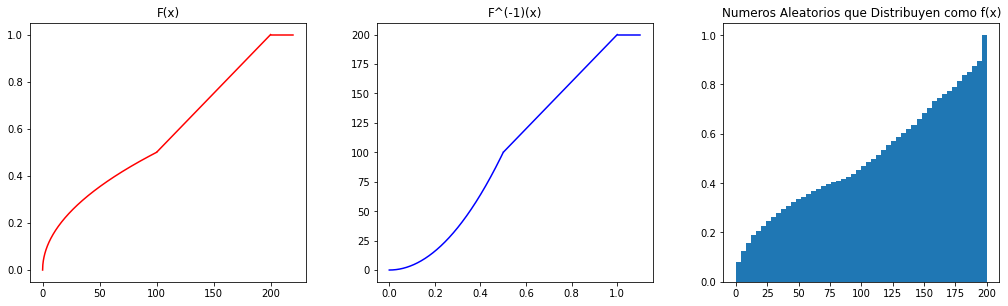

In [17]:
N = 1000 # Número de muestras
x = MTI_Por_Partes(N) # Corremos la funcion de la Transformada Inversa por Partes
# GRAFICAS
fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.tight_layout(pad=4.0)
# Grafica de F(x)
f_1 = lambda x: (np.sqrt(x))/20
f_2 = lambda x: x/200
f_3 = lambda x: x/x
x_space = np.linspace(0, 220, 1100)
ax[0].plot(x_space[0:500], f_1(x_space[0:500]), c="r")
ax[0].plot(x_space[501:1000], f_2(x_space[501:1000]), c="r")
ax[0].plot(x_space[1001:1100], f_3(x_space[1001:1100]), c="r")
ax[0].set_title('F(x)')
# Grafica de f(x)
f_1 = lambda x: (20*x)**2
f_2 = lambda x: 200*x
f_3 = lambda x: 200*(x/x)
x_space = np.linspace(0, 1.1, 1100)
ax[1].plot(x_space[0:500], f_1(x_space[0:500]), c="b")
ax[1].plot(x_space[501:1000], f_2(x_space[501:1000]), c="b")
ax[1].plot(x_space[1001:1100], f_3(x_space[1001:1100]), c="b")
ax[1].set_title('F^(-1)(x)')
# Grafica de numeros aleatorios que distribuyen como f(x)
ax[2].hist(x, bins = 50, cumulative=True, density=True)
ax[2].set_title('Numeros Aleatorios que Distribuyen como f(x)')
plt.show()

b). Repita el inciso anterior pero en esta ocasión utilice el método de aceptación y rechazo para generar las muestras aleatorias. 

In [18]:
# Función de aceptación y rechazo usando compresión de listas
def Acep_rechazo_distribution_por_partes_1(R2:'Variables distruidas U~U(0,1)', 
                                           R1:'Variables distribuidas como g(x)',
                                           t:'función que mayora a f',
                                           f_1:'función objetivo a generar',
                                           f_2:'función objetivo a generar',
                                           f_3:'función objetivo a generar'):
    R1.sort()  # Para que la funcion por partes los considere sin necesitar condiciones es mejor ordenarlos (por se uniforme)
    # Evaluamos las funciones por partes
    f_x_1 = f_1(R1[0:5000])
    f_x_2 = f_2(R1[5000:10000])
    # f_x_3 = f_3(R1[])
    # Unimos todo en una sola funcion
    f_x = list(f_x_1) + list(f_x_2)
    t_x = t(R1)
    condition = R2*t_x <=f_x
    df = pd.DataFrame([R1,R2*t_x,np.zeros(len(R1))]).transpose()
    df[2] = [True if condition[i] else False for i in range(len(R1))]
    [plt.plot(R1[i],R2[i]*t_x[i],'ob') if df[2][i] == True else plt.plot(R1[i],R2[i]*t_x[i],'o') for i in range(len(R1))]          
    plt.show()
    return df

El máximo de f es: 200


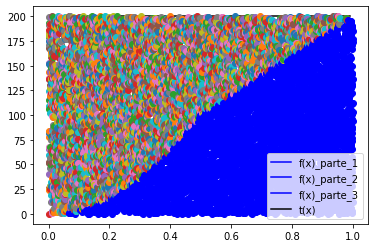

In [19]:
# Método de aceptación y rechazo cuando se toma t(x) constante
f_1 = f_1 # Función objetivo  
f_2 = f_2 # Función objetivo  
f_3 = f_3 # Función objetivo  
max_f = 200 # Máximo de la función f
t = lambda x: max_f*np.ones(len(x)) # Función t -> Función constante
x = np.arange(0,1,0.01)  # Rango donde se graficará las funciones
print('El máximo de f es:',max_f)
# Gráficas de las funciones
plt.plot(x[0:51],f_1(x[0:51]),label='f(x)_parte_1', c="b")
plt.plot(x[50:101],f_2(x[50:101]),label='f(x)_parte_2', c="b")
plt.plot(x[100:110],f_3(x[100:110]),label='f(x)_parte_3', c="b")
plt.plot(x,t(x),label='t(x)', c="k")
plt.legend()
# Validación del método
N = 10000 # número de puntos a simular
# Como estoy tomando t(x) constante solo es necesario generar valores aleatorios 
# uniformer entre el dominio de la función f(x) que para este ejemplo es [0,1]. Por
# lo tanto yo debo de generar R1 como un uniforme entre U ~(0,1)
R2 = np.random.rand(N)
R1 = np.random.uniform(0,1,N)
MAR_df = Acep_rechazo_distribution_por_partes_1(R2,R1,t,f_1,f_2,f_3)  # Regresa un DataFrame con Cada punto y si es Aceptado o Rechazado

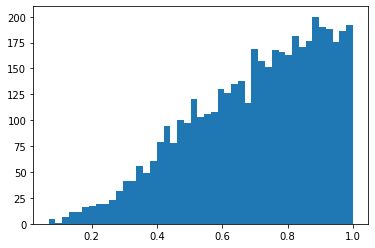

In [20]:
MAR_df = MAR_df[(MAR_df[2]==True)]   # Filtro solo los Aceptados
plt.hist(MAR_df[0], bins = 45)  # Hago un histograma de los datos aleatorios Simulados
plt.show()

# 3
Considere la siguiente función de distribución de probabilidad
$$ p_k = P\{X=k\}=\frac{10\,!}{k\,!(10-k)\,!}\big(\frac{1}{2}\big)^k\big(\frac{1}{2}\big)^{10-k}$$

a). Para realizar una comparación, realice el desarrollo analítico del valor esperado.

$$ p_k = P\{X=k\}=\frac{10\,!}{k\,!(10-k)\,!}\big(\frac{1}{2}\big)^k\big(\frac{1}{2}\big)^{10-k} = \frac{10\,!}{k\,!(10-k)\,!}\big(\frac{1}{2}\big)^{10} = \frac{1}{1024} \frac{10\,!}{k\,!(10-k)\,!}$$ 

Integramos la distribucion de probabilidad (discreta) de 0 a 10:

$$\frac{1}{1024} \sum_{k=0}^{10} \frac{10\,!}{k\,!(10-k)\,!} = \frac{1}{1024} (1 + 10 + 45 + 120 + 210 + 252 + 210 + 120 + 45 + 10 + 1) = \frac{1}{1024} (1024) = 1 $$

El valor esperado es cada evento por su probabilidad individual dividido entre la cantidad de eventos:

$$ E[p_{k}] = \frac{(0)(1)}{1024} + \frac{(1)(10)}{1024} + \frac{(2)(45)}{1024} + \frac{(3)(120)}{1024} + \frac{(4)(210)}{1024} + \frac{(5)(252)}{1024} + \frac{(6)(210)}{1024} + \frac{(7)(120)}{1024} + \frac{(8)(45)}{1024} + \frac{(9)(10)}{1024} + \frac{(10)(1)}{1024} = 5$$

b). Utilice el método de aceptación y rechazo para generar 1000 muestras aleatorias que distribuyan según la distribución $p_k$. Grafique el histograma de dichas muestras aleatorias obtenidas y a su vez la función de densidad $p_k(x)$, para validar los resultados obtenidos. **Sugerencia**: Revise los ejercicios realizados en la clase 15. Los resultados esperados son como se muestran en la siguiente gráfica:
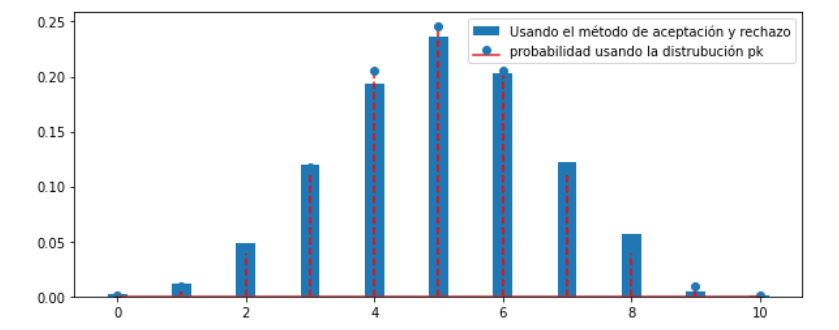

<font color ='red'>  **Nota**: Recuerde que $p_k$ es una distribución de probabilidad discreta así que los histogramas realizados deben ser discretos y no continuos. Utilice la función `np.unique` y `plt.bar` para graficar correctamente el histograma </font>


El máximo de f es: 0.24609375


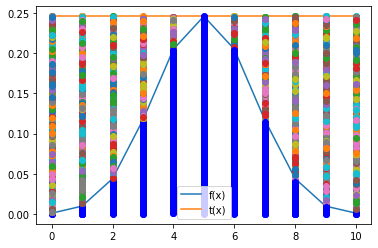

In [21]:
# Método de aceptación y rechazo cuando se toma t(x) constante
f = lambda a: [(1/1024)*((math.factorial(10))/((math.factorial(x))*(math.factorial(10-x)))) for x in a]
max_f = 252/1024 # Máximo de la función f
t = lambda x: max_f*np.ones(len(x)) # Función t -> Función constante
x = np.arange(0,11,1)  # Rango donde se graficará las funciones
print('El máximo de f es:',max_f)
# Gráficas de las funciones
plt.plot(x,f(x),label='f(x)')
plt.plot(x,t(x),label='t(x)')
plt.legend()
# Validación del método
N = 10000 # número de puntos a simular
# Como estoy tomando t(x) constante solo es necesario generar valores aleatorios 
# uniformer entre el dominio de la función f(x) que para este ejemplo es [15,90]. Por
# lo tanto yo debo de generar R1 como un uniforme entre U ~(15,90)
R2 = np.random.rand(N)
R1 = [random.randint(0, 10) for a in range(N)]
MAR_df = Acep_rechazo_distribution(R2,R1,f,t)  # Regresa un DataFrame con Cada punto y si es Aceptado o Rechazado

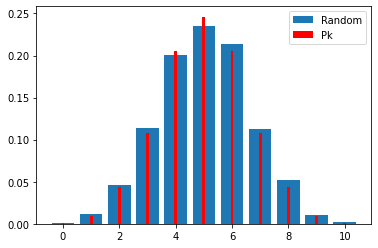

In [22]:
# Con Datos Aleatorios
MAR_df = MAR_df[(MAR_df[2]==True)]   # Filtro solo los Aceptados
barras = MAR_df[0].value_counts().sort_index()
indexes_1 = list(barras.index)
indexes_2 = list(np.array([0, 1 ,2 ,3 ,4 , 5, 6, 7, 8, 9, 10]))
heights_1 = list(barras/len(MAR_df))
# Con Distribución Pk (Teorico)
heights_2 = list(np.array([1, 10, 45, 110, 210, 252, 210, 110, 45, 10, 1])*(1/1024))
# Graficas
plt.bar(indexes_1, heights_1, label='Random')  # Hago un histograma de los datos aleatorios Simulados
plt.bar(indexes_2, heights_2, 0.1, label='Pk', color='r--')
plt.legend()
plt.show()

**Se desea estimar la media de esta distribución, usando el método montecarlo crudo y sus técnicas de reducción de varianza con muestras de tamaño 10,100 y 1000. Estas cantidades de muestras para cada uno de los siguientes literales:** 

c). Use el método de montecarlo crudo para estimar la media.

In [23]:
# Definimos la tabla donde se mostrarán los resultados
df = pd.DataFrame(index=['Montecarlo Crudo', 'errorMC %', 'Estratificado','errorE1 %',
                        'Complementarios', 'errorCom %', 'N Estratos','errorE2 %'],
                  columns=['N=10', 'N=100', 'N=1000'], dtype='float')
df.index.name = "Método y Erores"

In [24]:
# Integración montecarlo
def int_montecarlo(f:'Función a integrar',
                   a:'Límite inferior de la integral',
                   b:'Límite superior de la integral',
                   U:'Muestra de números U~[a,b]'):
    res = (b-a+1)/(len(U))*np.sum(f(U)) 
    print('La media por el metodo de MonteCarlo Crudo es de ' + str(len(U)) + ' muestras es de: ',res)
    return res

# Aqui es MÁS 1 es por ser discreta (de 0 - 10 hay 11 valores, no 10-0 = 10)

In [25]:
I = 5
# intervalo de integración
a = 0; b = 10
# Cantidad de términos, en escala logarítmica
N = np.logspace(1,3,3,dtype=int)
# Números aleatorios dependiente de la cantidad de términos N
ui = list(map(lambda p:[random.randint(0, 10) for a in range(p)], N))
# Calculamos la aproximación por montecarlo dependiendo de la cantidad de términos que hayamos creado con ui
f = lambda a: [(x/1024)*((math.factorial(10))/((math.factorial(x))*(math.factorial(10-x)))) for x in a]
I_m = list(map(lambda Y:int_montecarlo(f,a,b,Y),ui))
# Mostramos los resultados en la tabla previamente creada
df.loc['Montecarlo Crudo'] = I_m
df.loc['errorMC %'] = np.abs(df.loc['Montecarlo Crudo']-I)*100/I

La media por el metodo de MonteCarlo Crudo es de 10 muestras es de:  3.0937500000000004
La media por el metodo de MonteCarlo Crudo es de 100 muestras es de:  4.58369140625
La media por el metodo de MonteCarlo Crudo es de 1000 muestras es de:  4.7957421875


d). Use el método de muestreo estratificado con 5 estratos $0\leq F(x)\leq0.3, 0.3\leq F(x)\leq0.5, 0.5\leq F(x)\leq0.7, 0.7\leq F(x)\leq0.9 $ y $0.9\leq F(x) \leq 1$. Reparta el total de muestras en los estratos de la siguiente forma: estrato 1, 2, 3, 4, 5, 20%,20%,25%,15% y 20% de las muestras respectivamente.

In [26]:
Estra_1 = list()
a = 0
b = 10
for N in [10, 100, 1000]:
    r1 = np.array([random.randint(0, 3) for a in range(np.int(N*0.20))])
    r2 = np.array([random.randint(3, 5) for a in range(np.int(N*0.20))])
    r3 = np.array([random.randint(5, 7) for a in range(np.int(N*0.30))])
    r4 = np.array([random.randint(7, 9) for a in range(np.int(N*0.10))])
    r5 = np.array([random.randint(9, 10) for a in range(np.int(N*0.20))])
    r  = [r1,r2,r3,r4,r5]
    # Pesos
    w1 = (len(r1)/N)/0.30
    w2 = (len(r2)/N)/0.20
    w3 = (len(r3)/N)/0.20
    w4 = (len(r4)/N)/0.20
    w5 = (len(r5)/N)/0.10
    w  = [w1, w2, w3, w4, w5]
    # Calculo
    Est_1 = list(map(lambda x: (x/1024)*((math.factorial(10))/((math.factorial(x))*(math.factorial(10-x)))), list(np.concatenate(r))))
    # Como el factorial no es vectorizado hay que reacomodar los valores para dividirlos entre sus pesos
    Est_2 = list([np.array(Est_1[0:np.int(N*0.20)]),
                      np.array(Est_1[np.int(N*0.20):np.int(N*0.40)]),
                      np.array(Est_1[np.int(N*0.40):np.int(N*0.70)]),
                      np.array(Est_1[np.int(N*0.70):np.int(N*0.90)]),
                      np.array(Est_1[np.int(N*0.90):np.int(N)])])
    res_base = np.concatenate([(Est_2[i]/w[i]) for i in range(len(r))])
    media = np.mean(res_base)*(b-a)
    print('La media por el metodo de Estratificado con ' + str(N) + ' muestras es de: ',media)
    Estra_1.append(media)
# Como es una dsitribución discreta, lo que obtengo en "media" es la posición o el percentil donde se encuentra
# La media, por lo que tengo que ajustar este valor conforme al dominio, que en este caso es [0,10]
df.loc['Estratificado'] = Estra_1
df.loc['errorE1 %'] = np.abs(df.loc['Estratificado']-I)*100/I

La media por el metodo de Estratificado con 10 muestras es de:  5.5517578125
La media por el metodo de Estratificado con 100 muestras es de:  5.2763671875
La media por el metodo de Estratificado con 1000 muestras es de:  5.19521484375


e). Use el método de los números complementarios.

In [27]:
def N_Comp_Discreto(m:'Numero de muestras',a:'lim_inf',b:'lim_sup'):
    # Generación de Números aleatorios
    ri = np.array([random.randint(a, b) for j in range(m)])
    xi = list(map(lambda x: (x/1024)*((math.factorial(10))/((math.factorial(x))*(math.factorial(10-x)))), list(ri)))
    # Números aleatorios complementarios
    ri_c = max(ri)-ri+min(ri)  # Aleatorio nuevo = Límite superior aleatorio generado - Aleatorio generado + Límite inferior aleatorio generado.
    xi_c = list(map(lambda x: (x/1024)*((math.factorial(10))/((math.factorial(x))*(math.factorial(10-x)))), list(ri_c)))
    # Como es una dsitribución discreta, lo que obtengo en "media" es la posición o el percentil donde se encuentra
    # La media, por lo que tengo que ajustar este valor conforme al dominio, que en este caso es [0,10]
    media = ((np.mean(xi)+np.mean(xi_c))/2)*(b-a+1)
    print('La media por el metodo de Num. Complementarios con ' + str(m) + ' muestras es de=', media)
    return media

In [28]:
N_Comp = [N_Comp_Discreto(10,0,10), N_Comp_Discreto(100,0,10), N_Comp_Discreto(1000,0,10)]
df.loc['Complementarios'] = N_Comp
df.loc['errorCom %'] = np.abs(df.loc['Complementarios']-I)*100/I

La media por el metodo de Num. Complementarios con 10 muestras es de= 6.0478515625
La media por el metodo de Num. Complementarios con 100 muestras es de= 4.85439453125
La media por el metodo de Num. Complementarios con 1000 muestras es de= 4.858154296875


f). Finalmente use el método de estratificación en el cúal se divide en N estratos.

In [29]:
def N_Estratos_Discreto(B:'número de estratos',a:'limite inferior',b:'limite superior', f:'Funcion a Evaluar'):
    delta = (b-a)/(B)
    v=[]
    i = 0
    while i < B:
        v.append(np.random.uniform(a+i*delta,a+(i+1)*delta,1))
        i+=1
    v = np.concatenate(v, axis=0 )
    v = np.round(v).astype(int)
    res = (b-a)/(len(v))*np.sum(f(v)) 
    print('La media por el metodo de MonteCarlo Crudo es de ' + str(B) + ' muestras es de: ',res)
    return res

In [30]:
N = [10,100,1000]
a = 0
b = 10
f = lambda a: [(x/1024)*((math.factorial(10))/((math.factorial(x))*(math.factorial(10-x)))) for x in a]
Rand_N = [N_Estratos_Discreto(i,a,b,f) for i in N]
df.loc['N Estratos'] = Rand_N
df.loc['errorE2 %'] = np.abs(df.loc['N Estratos']-I)*100/I

La media por el metodo de MonteCarlo Crudo es de 10 muestras es de:  4.990234375
La media por el metodo de MonteCarlo Crudo es de 100 muestras es de:  4.9951171875
La media por el metodo de MonteCarlo Crudo es de 1000 muestras es de:  4.9951171875


g). Compare todos los resulados obtenidos con cada método en una tabla unsando la librería pandas, donde muestre segun la cantidad de términos usados, la aproximación de la media aproximada y su error relativo con el valor obtenido en el inciso a). Se espera que reportes tus resultados como se muestra a continuación:
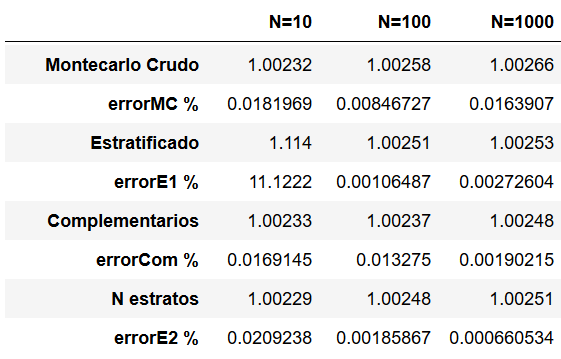

In [31]:
df

,N=10,N=100,N=1000
Método y Erores,,,
Montecarlo Crudo,3.093750,4.583691,4.795742
errorMC %,38.125000,8.326172,4.085156
Estratificado,5.551758,5.276367,5.195215
errorE1 %,11.035156,5.527344,3.904297
Complementarios,6.047852,4.854395,4.858154
errorCom %,20.957031,2.912109,2.836914
N Estratos,4.990234,4.995117,4.995117
errorE2 %,0.195312,0.097656,0.097656


# 4
Utilice la siguiente integral para aproximar el valor de `e`
## $$ I = \int_0^1 e^x dx $$
## <font color = 'red'> Nota: </font> Use el método de integración montecarlo visto en clase.
    
a). Use el método de montecarlo para aproximar el valor de `e` para muestras de tamaño 100,1000,10000,1000000 y comparelo con su valor real. 

$$ I = \int_0^1 e^x dx = [e^x]_{0}^{1} = e - 1 \longrightarrow I + 1 = e $$

In [32]:
# Definimos la tabla donde se mostrarán los resultados
df_2 = pd.DataFrame(index=['Montecarlo Crudo', 'errorMC %', 'Estratificado','errorE1 %',
                        'Complementarios', 'errorCom %', 'N Estratos','errorE2 %'],
                  columns=['N=100', 'N=1000', 'N=10000', 'N=1000000'], dtype='float')
df_2.index.name = "Método y Erores"

In [33]:
def int_euler(f:'Función a integrar',
                   a:'Límite inferior de la integral',
                   b:'Límite superior de la integral',
                   U:'Muestra de números U~[a,b]'):
    res = (b-a)/(len(U))*np.sum(f(U)) + 1
    print('La media por el metodo de MonteCarlo Crudo es de ' + str(len(U)) + ' muestras es de: ',res)
    return res

In [34]:
I = np.exp(1)
f = lambda a: [np.exp(x) for x in a]
N = [100, 1000, 10000, 1000000]
# Números aleatorios dependiente de la cantidad de términos N
a = 0; b = 1
ui = [np.random.uniform(a,b,p) for p in N]
I_m_2 = list(map(lambda Y:int_euler(f,a,b,Y),ui))
df_2.loc['Montecarlo Crudo'] = I_m_2
df_2.loc['errorMC %'] = np.abs(df_2.loc['Montecarlo Crudo']-I)*100/I

La media por el metodo de MonteCarlo Crudo es de 100 muestras es de:  2.674668021135495
La media por el metodo de MonteCarlo Crudo es de 1000 muestras es de:  2.734141779272508
La media por el metodo de MonteCarlo Crudo es de 10000 muestras es de:  2.7190299980110337
La media por el metodo de MonteCarlo Crudo es de 1000000 muestras es de:  2.7178874355042533


b). Repita el inciso anterior usando todos los método de reducción de varianza utilizados en el ejercicio *3*, para constrastar los resultados. Muestre los resultados en un dataframe como en el ejercicio *3-g)* y finalmente concluya  sus resultados.

In [35]:
Estra_1 = list()
for N in [100, 1000, 10000, 1000000]:
    r1 = np.array([random.uniform(0, 0.3) for a in range(np.int(N*0.20))])
    r2 = np.array([random.uniform(0.3, 0.5) for a in range(np.int(N*0.20))])
    r3 = np.array([random.uniform(0.5, 0.7) for a in range(np.int(N*0.30))])
    r4 = np.array([random.uniform(0.7, 0.9) for a in range(np.int(N*0.10))])
    r5 = np.array([random.uniform(0.9, 1) for a in range(np.int(N*0.20))])
    r  = [r1,r2,r3,r4,r5]
    # Pesos
    w1 = (len(r1)/N)/0.30
    w2 = (len(r2)/N)/0.20
    w3 = (len(r3)/N)/0.20
    w4 = (len(r4)/N)/0.20
    w5 = (len(r5)/N)/0.10
    w  = [w1, w2, w3, w4, w5]
    # Calculo
    Est_1 = list(map(lambda x: np.exp(x) + 1,r))
    res_base = np.concatenate([(Est_1[i]/w[i]) for i in range(len(r))])
    media = np.mean(res_base)
    print('La media por el metodo de Estratificado con ' + str(N) + ' muestras es de: ',media)
    Estra_1.append(media)
df_2.loc['Estratificado'] = Estra_1
df_2.loc['errorE1 %'] = np.abs(df_2.loc['Estratificado']-I)*100/I

La media por el metodo de Estratificado con 100 muestras es de:  2.722076234574707
La media por el metodo de Estratificado con 1000 muestras es de:  2.7153527485686344
La media por el metodo de Estratificado con 10000 muestras es de:  2.7161440876785816
La media por el metodo de Estratificado con 1000000 muestras es de:  2.718088383672993


In [36]:
def N_Complementrios(m:'Numero de muestras'):
    # Generación de Números aleatorios
    ri = np.random.rand(m)
    xi = np.exp(ri) + 1
    # Media de observaciones aleatorias
    m_rand = np.mean(xi)
    # Números aleatorios complementarios
    ri_c = max(ri)-ri+min(ri)  # Aleatorio nuevo = Límite superior aleatorio generado - Aleatorio generado + Límite inferior aleatorio generado.
    xi_c = np.exp(ri_c) + 1
    # Media de observaciones complementarias
    media = ((np.mean(xi)+np.mean(xi_c))/2)
    print('La media por el metodo de Num. Complementarios con ' + str(m) + ' muestras es de=', media)
    return media

N_Comp_2 = [N_Complementrios(100), N_Complementrios(1000), N_Complementrios(10000), N_Complementrios(1000000)]
df_2.loc['Complementarios'] = N_Comp_2
df_2.loc['errorCom %'] = np.abs(df_2.loc['Complementarios']-I)*100/I

La media por el metodo de Num. Complementarios con 100 muestras es de= 2.734761493002794
La media por el metodo de Num. Complementarios con 1000 muestras es de= 2.716898159600147
La media por el metodo de Num. Complementarios con 10000 muestras es de= 2.7183628229576744
La media por el metodo de Num. Complementarios con 1000000 muestras es de= 2.718355409304375


In [37]:
def N_Estratos(B:'número de estratos',a:'limite inferior',b:'limite superior', f:'Funcion a Evaluar'):
    delta = (b-a)/(B)
    v=[]
    i = 0
    while i < B:
        v.append(np.random.uniform(a+i*delta,a+(i+1)*delta,1))
        i+=1
    v = np.concatenate(v, axis=0 )
    res = (b-a)/(len(v))*np.sum(f(v)) 
    print('La media por el metodo de MonteCarlo Crudo es de ' + str(B) + ' muestras es de: ',res)
    return res

In [38]:
N = [100,1000,10000,1000000]
a = 0
b = 1
f = lambda a: [np.exp(x) + 1 for x in a]
Rand_N_2 = [N_Estratos(i,a,b,f) for i in N]
df_2.loc['N Estratos'] = Rand_N_2
df_2.loc['errorE2 %'] = np.abs(df_2.loc['N Estratos']-I)*100/I

La media por el metodo de MonteCarlo Crudo es de 100 muestras es de:  2.7188182193406516
La media por el metodo de MonteCarlo Crudo es de 1000 muestras es de:  2.7182907010444324
La media por el metodo de MonteCarlo Crudo es de 10000 muestras es de:  2.718282112495039
La media por el metodo de MonteCarlo Crudo es de 1000000 muestras es de:  2.718281827650883


In [39]:
df_2

,N=100,N=1000,N=10000,N=1000000
Método y Erores,,,,
Montecarlo Crudo,2.674668,2.734142,2.719030,2.717887e+00
errorMC %,1.604462,0.583455,0.027524,1.450891e-02
Estratificado,2.722076,2.715353,2.716144,2.718088e+00
errorE1 %,0.139588,0.107755,0.078643,7.116436e-03
Complementarios,2.734761,2.716898,2.718363,2.718355e+00
errorCom %,0.606253,0.050902,0.002980,2.706888e-03
N Estratos,2.718818,2.718291,2.718282,2.718282e+00
errorE2 %,0.019733,0.000326,0.000010,2.973062e-08


# 5

La distribución de Pareto se ha utilizado en economía como modelo para una función de densidad con una cola que decae lentamente:
$$
f(x|x_0,\theta)= \theta x_0^\theta x^{-\theta -1}, \quad x\geq x_0, \quad \theta>1
$$
Asuma que $x_0>0$ y que es dado y que $X_1,X_2,\cdots,X_n$ es una muestra de variables aleatorias independientes idénticamente distribuidas. Use el método de Método de máxima verosimilitud para estimar theta. Realice todos los cálculos necesarios usando la sintáxis markdown. Para validar tus resultados teóricos obtenidos grafique la función verosimilitud para distintos valores the $\theta$. Para esto asuma $n=30$ $\sum_{i=1}^n \ln X_i = 15$ , $x_0=5$.

**Nota**:
La gráfica grafique $\theta$ vs función de verosimilitud  debe ser algo como sigue
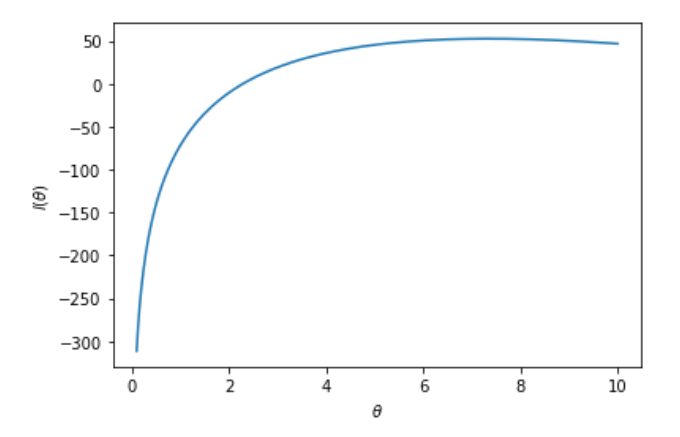


Función de densidad::
$$f(x|x_0,\theta)= \theta x_0^\theta x^{-\theta -1}, \quad x\geq x_0, \quad \theta>1$$

La distribución de Pareto pertenece a la familia de distribuciones exponenciales y se puede reescribir como:

$$p_{0}(x) = (\theta) x_0^{\theta} e^{\sum_{i=1}^{n} -(\theta + 1) * ln(x_{i})}$$

Sabemos que: $n=30$, $x_0>0$ y que $x_0=5$



$$p_{0}(x) = (\theta) (5^{\theta}) e^{\sum_{i=1}^{30} -(\theta + 1) * ln(x_{i})}$$

$$p_{0}(x) = (\theta) (5^{\theta}) e^{ -(\theta + 1) \sum_{i=1}^{30} ln(x_{i})}$$


Sabemos que: , $X_1,X_2,\cdots,X_n$ es una muestra aleatoria Uniforme, $\sum_{i=1}^{n} \ln (X_i) = 15$ , entonces:

$$f(\theta) = (\theta) (5^{\theta}) e^{ -15(\theta + 1)}$$



Nota: https://www.casact.org/library/astin/vol20no2/201.pdf

In [186]:
Theta = list(np.linspace(6,10,9))
f = lambda t: (t)*(5**t)*np.exp(-15*(t+1))

In [187]:
f_t = [f(a) for a in Theta]

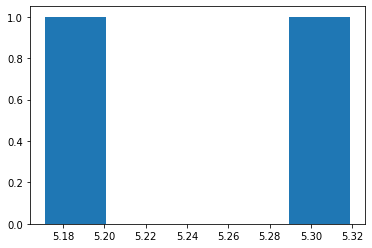

In [212]:
y_random_1 = st.pareto.rvs(5,3,2,2)
y1, x1, _ = plt.hist(y_random_1, bins=5)


In [ ]:
# DATA
loc_1, scale_1 = st.laplace.fit(measurements_1)  
loc_2, scale_2 = st.gumbel_r.fit(measurements_2)  
# Usando Maxima Verosimilitud
y_random_1 = st.laplace.rvs(loc=loc_1, scale=scale_1, size=10000)
y_random_2 = st.gumbel_r.rvs(loc=loc_2, scale=scale_2, size=10000)
# 
y_1, x_1, _ = plt.hist(measurements_1, bins=60, density = True)
y1, x1, _ = plt.hist(y_random_1, bins=60, density = True)
y_2, x_2, _ = plt.hist(measurements_2, bins=60, density = True)
y2, x2, _ = plt.hist(y_random_2, bins=60, density = True)
plt.close()
# GRAFICOS 
fig, ax = plt.subplots(2,2, figsize=(15,10))
fig.tight_layout(pad=4.0)
# PRIMERA DISTRIBUCIÓN
ax[0,0].hist(measurements_1, bins=60, density = True)  # Histograma
ax[0,0].set_ylabel('Probability')
ax[0,0].set_title('Histograma de Datos Originales')
ax[0,0].grid()
# Gráfica con Maxima Verosimilitud
ax[0,1].hist(y_random_1, bins=60, density = True)
ax[0,1].plot(x_1[1:], y_1, 'r')
ax[0,1].grid()
ax[0,1].set_title('Usando Aleatorios y Max Verosimilitud')
# SEGUNDA DISTRIBUCIÓN
ax[1,0].hist(measurements_2, bins=60, density = True)  # Histograma
ax[1,0].set_ylabel('Probability')
ax[1,0].set_title('Histograma de Datos Originales')
ax[1,0].grid()
# Gráfica con Maxima Verosimilitud
ax[1,1].hist(y_random_2, bins=60, density = True)
ax[1,1].plot(x_2[1:], y_2, 'r')
ax[1,1].grid()
ax[1,1].set_title('Usando Aleatorios y Max Verosimilitud')
plt.show()

**Valor de los ejercicios**
- 1- 4 puntos
- 2- 2 puntos
- 3- 5 puntos
- 4- 2 puntos
- 5- 2 puntos


<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Zuluaga.
</footer>